# Checking calibrations

Here I am just checking the calibrations measured for all $z-\lambda$ bins.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
import emcee
import corner
%matplotlib inline
plt.rc("errorbar", capsize=3)

In [2]:
sig = 0.05
path = "result_%0.2fsigintr.npy"%sig
data = np.load(path)
print(data.shape)
cs = ['maroon','red','blue','cyan']
zs = [1.0, 0.5, 0.25, 0.]

(6, 16)


In [3]:
def add_points(ax, sigma=None):
    for i in range(4):
        for j in range(4):
            h = i*4+j
            lam = data[3,h]
            c = data[4,h]
            ce = data[5,h]
            if sigma is not None:
                ce = sigma
            if j == 0:
                ax.errorbar(lam, c, ce, color=cs[i], marker='.', label="z=%.2f"%zs[i], ls='')
            else:
                ax.errorbar(lam, c, ce, color=cs[i], marker='.')
    ax.set_ylim(0.9, 1.15)
    ax.legend(loc="upper left")

# Modeling the calibration

In [4]:
def lnlike(params, args, ret_model=False):
    C0, alpha, beta, sigcal = params
    if sigcal < 0: return -1e99
    lams = args['lams'].T
    zs = args['zs']
    #print(lams)
    #print(zs)
    C = args['C']
    Cerr = args['Cerr']
    model = C0*(lams/30.)**alpha * ((1+zs)/1.5)**beta
    if ret_model:
        return model
    X = C - model
    LL = 0
    for i in range(len(X)):
        for j in range(len(X[0])):
            LL += -0.5*np.log(sigcal**2)-0.5*X[i,j]**2/sigcal**2
    return LL

In [5]:
zs = [1.0, 0.5, 0.25, 0.]
zarr = np.zeros((4,4))
lamarr = np.zeros((4,4))
C = np.zeros((4,4))
Ce = np.zeros((4,4))
for i in range(16):
    zarr[i%4, i/4] = zs[i%4]
    lamarr[i%4, i/4] = data[3, i]
    C[i%4, i/4] = data[4,i]
    Ce[i%4, i/4] = data[5,i]
args = {"lams": lamarr, "zs":zarr, "C":C, "Cerr":Ce}

In [6]:
guess = [1.0, 0.02 ,0.02, 0.1]
print(lnlike(guess, args))
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, guess, args=args)
cov = result['hess_inv']
print result

35.314056331294026
      fun: -67.52356950990985
 hess_inv: array([[ 7.22219646e-06, -4.97826088e-06,  5.29030660e-06,
         2.97173466e-07],
       [-4.97826088e-06,  1.59800250e-05,  2.90397218e-07,
         3.07026645e-07],
       [ 5.29030660e-06,  2.90397218e-07,  5.94655566e-05,
         9.89574445e-07],
       [ 2.97173466e-07,  3.07026645e-07,  9.89574445e-07,
         2.48100714e-06]])
      jac: array([ 6.67572021e-06,  4.76837158e-06, -1.90734863e-06,  2.86102295e-06])
  message: 'Optimization terminated successfully.'
     nfev: 284
      nit: 22
     njev: 45
   status: 0
  success: True
        x: array([ 1.04349913, -0.02269669, -0.05279047,  0.00891318])


(0.95, 1.15)

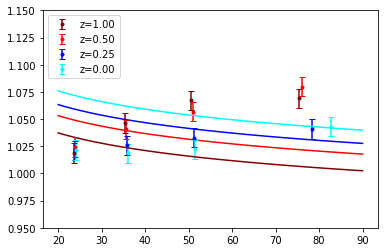

In [7]:
fig, ax = plt.subplots(1,1)
l = np.linspace(20,90)
plot_args = args.copy()
for i,z in enumerate(zs):
    plot_args['lams'] = l
    plot_args['zs'] = z
    model = lnlike(result.x, plot_args, True)
    ax.plot(l, model, c=cs[i])
add_points(ax, result.x[-1])
ax.set_ylim(.95,1.15)

In [8]:
ndim = 4
nwalkers = 32
nsteps = 1000
nburn = 200
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike, args=(args,), threads=4)

In [9]:
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler.run_mcmc(pos, nburn)
print("burn in done")

burn in done


In [10]:
chain = sampler.chain
pos = chain[:,-1,:]
print(chain.shape)

(32, 200, 4)


In [11]:
sampler.reset()

In [12]:
sampler.run_mcmc(pos, nsteps)
print("mcmc complete")

mcmc complete


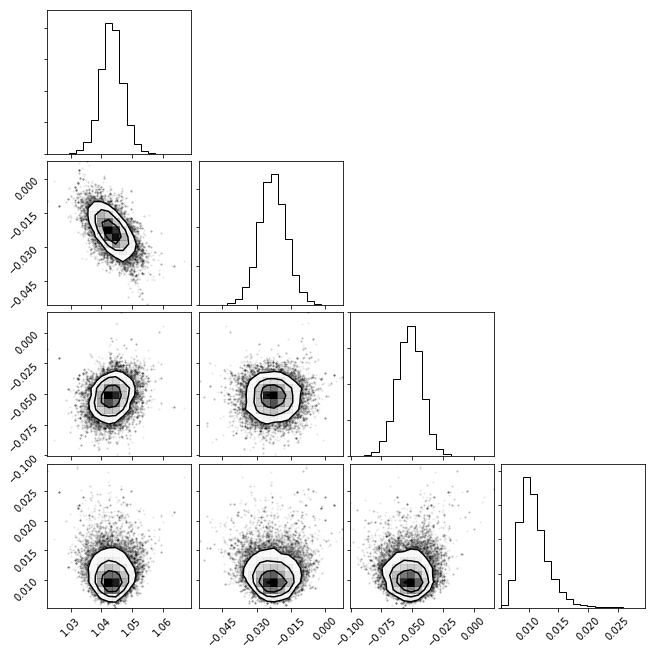

In [13]:
chain = sampler.flatchain
lnlikes = sampler.flatlnprobability
fig = corner.corner(chain)
cov = np.cov(chain.T)

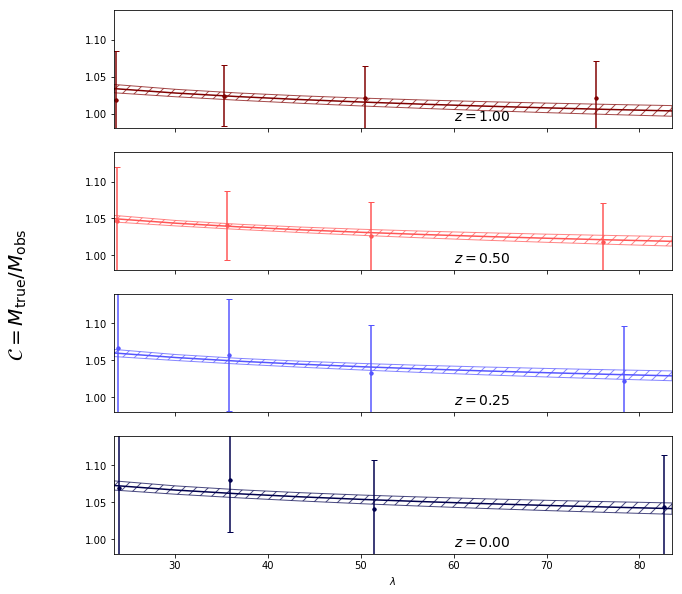

In [14]:
zs = [1.0, 0.5, 0.25, 0.]
fig, ax = plt.subplots(4,1, sharex=True, figsize=(10,10))
colors = [plt.get_cmap("seismic")(ci) for ci in np.linspace(1.0, 0.0, len(zs))]
C0, a, b, sc = chain[np.argmax(lnlikes)]
vC0,va,vb, vsc = cov.diagonal()
cal = args['C']
scal = args['Cerr']
lams = args['lams'].T
lamx = np.linspace(np.min(lams)*0.99, np.max(lams)*1.01, num=10)
for i in range(len(zs)):
    C = C0 * (lamx/30.)**a * ((1+zs[i])/1.5)**b
    C_err = np.sqrt(vC0*C**2/C0**2 + va*C**2*np.log(lamx/30.)**2 + vb*C**2*np.log((1+zs[i])/1.5)**2 + cov[0,1]*C**2/C0*np.log(lamx/30.) + cov[0,2]*C**2/C0*np.log((1+zs[i])/1.5) + cov[1,2]*C**2*np.log(lamx/30.)*np.log((1+zs[i])/1.5))
    ax[i].plot(lamx, C, c=colors[i])
    ax[i].fill_between(lamx, C+C_err, C-C_err, alpha=0.7, hatch='//', facecolor='none', edgecolor=colors[i])
    ax[i].errorbar(lams[i], cal[i], scal[i], marker='.', ls='', c=colors[i])
    ax[i].scatter(lams[i], cal[i], marker='.', color=colors[i])
    yulim = 1.14
    ax[i].set_ylim(0.98, yulim)
    ax[i].set_xlim(min(lamx), max(lamx))
    ax[i].text(60, 0.99, r"$z=%.2f$"%zs[i], fontsize=14)
    if i == 2:
        ax[i].text(12, yulim, r"$\mathcal{C}=M_{\rm true}/M_{\rm obs}$", rotation='vertical', fontsize=20, va='center') 
    ax[-1].set_xlabel(r"$\lambda$")
fig.savefig("calibration_sigint%dpercent.png"%(100*sig), dpi=300, bbox_inches='tight')

In [15]:
print(C0, a, b, sc)

(1.0437189605264163, -0.023368908833290476, -0.05299171755841266, 0.008779615772312972)
